# Imports

In [1]:
import os
import paddle
import torchvision
import torch
import torch.nn as nn
import numpy as np
import paddle.sparse
import seaborn as sns
import networkx as nx

from paddle.learning import train, test
from torchvision.transforms import transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Some two-layer structure

In [ ]:
structure = paddle.sparse.CachedLayeredGraph()
structure.add_nodes_from(np.arange(1, 7))

block0_size = 50
block1_size = 50
block2_size = 30
block3_size = 30
block4_size = 30
block5_size = 20
block6_size = 20
block0 = np.arange(1, block0_size+1)
block1 = np.arange(block0_size+1, block0_size+block1_size+1)
block2 = np.arange(block0_size+block1_size+1, block0_size+block1_size+block2_size+1)
block3 = np.arange(block0_size+block1_size+block2_size+1, block0_size+block1_size+block2_size+block3_size+1)
block4 = np.arange(block0_size+block1_size+block2_size+block3_size+1, block0_size+block1_size+block2_size+block3_size+block4_size+1)
block5 = np.arange(block0_size+block1_size+block2_size+block3_size+block4_size+1, block0_size+block1_size+block2_size+block3_size+block4_size+block5_size+1)
block6 = np.arange(block0_size+block1_size+block2_size+block3_size+block4_size+block5_size+1, block0_size+block1_size+block2_size+block3_size+block4_size+block5_size+block6_size+1)

# First layer
for v in block0:
    for t in block2:
        structure.add_edge(v, t)
for v in block0:
    for t in block3:
        structure.add_edge(v, t)
for v in block1:
    for t in block3:
        structure.add_edge(v, t)
for v in block1:
    for t in block4:
        structure.add_edge(v, t)

# Second layer
for v in block2:
    for t in block5:
        structure.add_edge(v, t)
for v in block3:
    for t in block5:
        structure.add_edge(v, t)
for v in block3:
    for t in block6:
        structure.add_edge(v, t)
for v in block4:
    for t in block6:
        structure.add_edge(v, t)

# Load mnist dataset

In [3]:
batch_size = 100

"""
MNIST
"""
custom_transform = transforms.Compose([
    transforms.ToTensor(),  # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # normalize inputs
])
# download and transform train dataset
mnist_train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/media/data/set/mnist/',
                                                          download=True,
                                                          train=True,
                                                          transform=custom_transform),
                                                           batch_size=batch_size,
                                                           shuffle=True)

# download and transform test dataset
mnist_test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/media/data/set/mnist/',
                                                         download=True,
                                                         train=False,
                                                         transform=custom_transform),
                                                          batch_size=batch_size,
                                                          shuffle=True)

In [ ]:
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = paddle.sparse.MaskedDeepDAN(784, 10, structure)
print(model)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
    print('Epoch', epoch)
    loss, perc = train(mnist_train_loader, model, optimizer, loss_func, device, percentage=True)
    print('Train', loss, perc)

    print('Test', test(mnist_test_loader, model, device))

In [ ]:
model.layers_main_hidden[1].mask.shape

In [ ]:
sns.heatmap(model.layers_main_hidden[0].mask.cpu().detach().numpy())

In [ ]:
sns.heatmap(model.layers_main_hidden[0].weight.cpu().detach().numpy())

In [ ]:
masked_weights = model.layers_main_hidden[0].weight.cpu().detach().numpy()*model.layers_main_hidden[0].mask.cpu().detach().numpy()
model.layers_main_hidden[0].weight = nn.Parameter(torch.cuda.FloatTensor(masked_weights))

In [ ]:
sns.heatmap(model.layers_main_hidden[0].weight.cpu().detach().numpy())

In [ ]:
print('Test', test(mnist_test_loader, model, device))

In [ ]:
sns.heatmap(model.layers_main_hidden[1].mask.cpu().detach().numpy())

In [ ]:
print('Test', test(mnist_test_loader, model, device))

## Load cifar10 Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_root = '/media/data/set/cifar10'
if not os.path.exists(dataset_root):
    os.makedirs(dataset_root)
cifar10_train_set = torchvision.datasets.CIFAR10(root=dataset_root, train=True, download=True, transform=transform)
cifar10_test_set = torchvision.datasets.CIFAR10(root=dataset_root, train=False, download=True, transform=transform)

cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_set,
                                                  batch_size=batch_size,
                                                  shuffle=True)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_set,
                                                  batch_size=batch_size,
                                                  shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_cifar10 = paddle.sparse.MaskedDeepDAN(32*32*3, 10, structure)
print(model_cifar10)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
model_cifar10.to(device)

optimizer = torch.optim.SGD(model_cifar10.parameters(), lr=0.01, momentum=0.5)
loss_func = nn.CrossEntropyLoss()

In [ ]:
epochs = 10
for epoch in range(epochs):
    print('Epoch', epoch)
    loss, perc = train(cifar10_train_loader, model_cifar10, optimizer, loss_func, device, percentage=True)
    print('Train', loss, perc)

    print('Test', test(cifar10_test_loader, model_cifar10, device))

In [ ]:
sns.heatmap(model_cifar10.layers_main_hidden[0].weight.cpu().detach().numpy())

In [ ]:
sns.heatmap(model_cifar10.layers_main_hidden[1].weight.cpu().detach().numpy())

In [4]:
#random_graph = nx.fast_gnp_random_graph(200, 0.5)
#random_graph = nx.balanced_tree(3, 10)
random_graph = nx.watts_strogatz_graph(200, 3, 0.7)
random_directed_graph = np.tril(nx.to_numpy_matrix(random_graph))
print(random_directed_graph)

structure = paddle.sparse.CachedLayeredGraph()
for source, targets in enumerate(random_directed_graph):
    for target, weight in enumerate(targets):
        if weight > 0:
            structure.add_edge(source, target)
#print(nx.to_numpy_matrix(structure))

model = paddle.sparse.MaskedDeepDAN(784, 10, structure)

for layer in structure.layers:
    print(structure.get_layer_size(layer))

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
loss_func = nn.CrossEntropyLoss()    

epochs = 10
for epoch in range(epochs):
    print('Epoch', epoch)
    loss, perc = train(mnist_train_loader, model, optimizer, loss_func, device, percentage=True)
    print('Train', loss, perc)

    print('Test', test(mnist_test_loader, model, device))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
56
49
36
25
13
11
5
3
1
1
cuda:0
Epoch 0
Train 2.2742526443799336 14.186666666666667
Test 20.63
Epoch 1
Train 2.1017670595645903 20.31833333333333
Test 20.95
Epoch 2
Train 2.015386228164037 21.22833333333333
Test 21.97
Epoch 3
Train 1.9664593760172526 22.115
Test 23.21
Epoch 4
Train 1.9381909801562627 23.343333333333334
Test 24.31
Epoch 5
Train 1.9112065227826436 24.795
Test 26.34
Epoch 6
Train 1.8778076835473378 26.16
Test 26.24
Epoch 7
Train 1.8415191694100699 26.686666666666667
Test 26.93
Epoch 8
Train 1.8091934766372044 27.35333333333333
Test 27.91
Epoch 9
Train 1.78273723979791 28.685
Test 28.28


In [ ]:
sns.heatmap(model.layers_main_hidden[1].mask.cpu().detach().numpy())

In [19]:
structure = paddle.sparse.CachedLayeredGraph()

block_structure = {
    0: (50, [5, 6, 7, 20, 21]),  # (capacity, [connected_to_block1, connected_to_block2, ..])
    1: (50, [5, 7, 21, 22]),
    2: (50, [6, 8, 20, 24]),
    3: (50, [7, 9, 22, 23]),
    4: (50, [8, 9, 23, 24]),
    
    5: (20, [10, 11, 12, 20]),
    6: (20, [11, 12, 13, 21]),
    7: (20, [13, 14, 15, 16, 22]),
    8: (20, [16, 17, 18, 23]),
    9: (20, [17, 18, 19, 24]),
    
    10: (10, [20, 21, 22]),
    11: (10, [21, 22, 23]),
    12: (10, [22, 23, 24]),
    13: (10, [20, 21, 22]),
    14: (10, [21, 22, 23]),
    15: (10, [22, 23, 24]),
    16: (10, [20, 21, 22, 23, 24]),
    17: (10, [20, 21, 22]),
    18: (10, [21, 22, 23]),
    19: (10, [22, 23, 24]),
    
    20: (10, []),
    21: (10, []),
    22: (10, []),
    23: (10, []),
    24: (10, [])
}

blocks = {}
block_offset = 0
targets = {}
for block in block_structure:
    capacity = block_structure[block][0]
    blocks[block] = np.arange(block_offset, block_offset+capacity)
    block_offset += capacity
for block in block_structure:
    targets = block_structure[block][1]
    for target_block in targets:
        for source_vtx in blocks[block]:
            for target_vtx in blocks[target_block]:
                structure.add_edge(source_vtx, target_vtx)

print(nx.to_numpy_matrix(structure).shape)

for layer in structure.layers:
    print('Layer size:', structure.get_layer_size(layer))

(500, 500)
Layer size: 250
Layer size: 100
Layer size: 100
Layer size: 50


In [20]:
model = paddle.sparse.MaskedDeepDAN(784, 10, structure)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
loss_func = nn.CrossEntropyLoss()    

epochs = 100
for epoch in range(epochs):
    print('Epoch', epoch)
    loss, perc = train(mnist_train_loader, model, optimizer, loss_func, device, percentage=True)
    print('Train', loss, perc)

    print('Test', test(mnist_test_loader, model, device))

cuda:0
Epoch 0
Train 0.9258166017383337 76.525
Test 90.16
Epoch 1
Train 0.31483462793131667 90.94166666666666
Test 92.49
Epoch 2
Train 0.25666981981446346 92.47666666666667
Test 93.43
Epoch 3
Train 0.22035176155467828 93.61833333333334
Test 94.29
Epoch 4
Train 0.19201463324949145 94.455
Test 94.63
Epoch 5
Train 0.16925397698457043 95.155
Test 95.16
Epoch 6
Train 0.15031055479620894 95.61333333333333
Test 95.64
Epoch 7
Train 0.13394322582210103 96.065
Test 95.82
Epoch 8
Train 0.12068376923600832 96.525
Test 96.22
Epoch 9
Train 0.10952180196841557 96.85833333333333
Test 96.46
Epoch 10
Train 0.09914997207932175 97.18833333333333
Test 96.76
Epoch 11
Train 0.09085985654965043 97.42666666666666
Test 96.96
Epoch 12
Train 0.08344741287951668 97.62333333333333
Test 96.88
Epoch 13
Train 0.07705044977056484 97.82166666666667
Test 97.24
Epoch 14
Train 0.07097822670203945 97.99
Test 97.09
Epoch 15
Train 0.06591400109619523 98.14333333333333
Test 97.45
Epoch 16
Train 0.0611507254683723 98.3
Test 97.

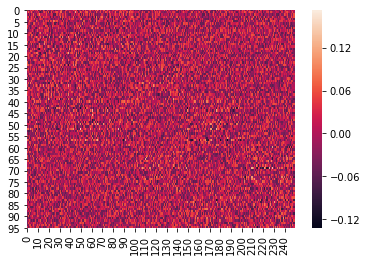

In [28]:
sns.heatmap(model.layers_main_hidden[0].weight.cpu().detach().numpy())

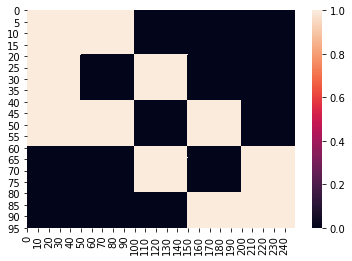

In [29]:
sns.heatmap(model.layers_main_hidden[0].mask.cpu().detach().numpy())